01_import dataset
===

In [1]:
import os
import json
import pandas as pd

#https://drive.google.com/drive/folders/18qV82fNY3IIWu3BRoGqm_LNgJzE8Akbr?usp=drive_link
#base_dir = "/Users/Andypon/10_交大研究所/1141_01_機器學習與金融科技/data"
base_dir= '/Users/andyw.p.chen/Documents/Project/datasets'
#base_dir=  "c:\Users\user\Downloads\datasets"

def load_json_to_df(filename: str) -> pd.DataFrame:
    file_path = os.path.join(base_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 如果是 { "target": {id: value, ...} }
    if isinstance(data, dict) and len(data) == 1 and isinstance(next(iter(data.values())), dict):
        key, inner = next(iter(data.items()))
        return pd.DataFrame(list(inner.items()), columns=["id", key])

    # dict of scalar
    if isinstance(data, dict):
        return pd.DataFrame([{"code": k, "desc": v} for k, v in data.items()])

    # list of dict
    elif isinstance(data, list):
        return pd.DataFrame(data)

    else:
        raise ValueError(f"Unsupported JSON structure in {filename}: {type(data)}")


def load_csv_to_df(filename: str) -> pd.DataFrame:
    """讀取 CSV 並轉為 DataFrame。"""
    return pd.read_csv(os.path.join(base_dir, filename))

# JSON 資料
##mcc_codes_df = load_json_to_df("mcc_codes.json")
train_fraud_labels_df = load_json_to_df("train_fraud_labels.json")

# CSV 資料
cards_df = load_csv_to_df("cards_data.csv")
transactions_df = load_csv_to_df("transactions_data.csv")
users_df = load_csv_to_df("users_data.csv")

# 簡單檢查
#print(mcc_codes_df.head())
#print(train_fraud_labels_df.head())
#print(cards_df.head())
#print(transactions_df.head())
#print(users_df.apthead())


02_rename variable in each data set
===

In [2]:
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'id': 'transactions_id'})
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'target': 'is_fraud'})

cards_df = cards_df.rename(columns={'id':'card_id'})

users_df = users_df.rename(columns={'id':'client_id'})

transactions_df = transactions_df.rename(columns={'mcc': 'mcc_code'})
transactions_df = transactions_df.rename(columns={'id': 'transaction_id'})




03_變數型態統一及缺失值處理
===

In [3]:
def add_missing_flags(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    在 DataFrame 中對指定欄位建立 missing flag 欄位
    flag=1 表示缺失值，flag=0 表示非缺失值
    
    參數
    ----
    df : pd.DataFrame
        輸入的資料框
    cols : list
        要檢查的欄位名稱清單
    
    回傳
    ----
    pd.DataFrame : 新的資料框 (含新增的 flag 欄位)
    """
    for col in cols:
        df[f"{col}_missing_flag"] = df[col].isna().astype(int)
    return df

transactions_df = add_missing_flags(transactions_df, ["merchant_state", "zip", "errors"])

In [4]:
##train_fraud_labels_df##
train_fraud_labels_df["is_fraud"]=train_fraud_labels_df["is_fraud"].astype("category") 
train_fraud_labels_df["transactions_id"]=train_fraud_labels_df["transactions_id"].astype(int) #合併資料需要

##cards_df##
cards_df["card_brand"]=cards_df["card_brand"].astype("category") 
cards_df["card_type"]=cards_df["card_type"].astype("category")
#####不要load這行 cards_df["expires"]=pd.to_datetime(cards_df["expires"], format="%m/%Y")
cards_df["expires"] = pd.to_datetime(cards_df["expires"], format="%m/%Y").dt.to_period("M")
cards_df["has_chip"]=cards_df["has_chip"].astype("category")

cards_df['credit_limit'] = cards_df['credit_limit'].replace(r'[\$,]', '', regex=True).astype(int)
#####不要load這行 cards_df["acct_open_date"]=pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y")
cards_df["acct_open_date"] = pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y").dt.to_period("M")
#####不要load這行 cards_df["year_pin_last_changed"]=pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y")
cards_df["year_pin_last_changed"] = pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y").dt.to_period("Y")
cards_df["card_on_dark_web"]=cards_df["card_on_dark_web"].astype("category") 

##users_df##
users_df["birth_year"] = pd.to_datetime(users_df["birth_year"], format="%Y").dt.to_period("Y")
users_df["birth_month"] = pd.to_datetime(users_df["birth_month"], format="%m").dt.to_period("M")
users_df["gender"]=users_df["gender"].astype("category") 
users_df['per_capita_income'] = users_df['per_capita_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['yearly_income'] = users_df['yearly_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['total_debt'] = users_df['total_debt'].replace(r'[\$,]', '', regex=True).astype(int)

##transactions_df##
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
#浮點數轉整數原因確定？
transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float).astype(int)
##負數取log調成1
#transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float)

transactions_df["use_chip"]=transactions_df["use_chip"].astype("category") 

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'merchant_state'
] = 'online'

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'zip'
] = -1
## 我沒有全部改，這樣完之後仍有89006筆Missing，剩下都是在國外
transactions_df['zip'] = transactions_df['zip'].fillna(-999)
transactions_df["zip"]=transactions_df["zip"].astype("int64")

transactions_df['errors'] = transactions_df['errors'].astype('category')
transactions_df['errors'] = transactions_df['errors'].cat.add_categories('No_error').fillna('No_error')



In [5]:
#cars one hot encoding
##統一類別變數轉dummy variable(要注意共線性問題，應刪掉其中之一)

#card_type 原始種類：Debit_57%, Credit_33%, Debit(Prepaid)_9%
#card_brand 原始種類：MasterCard_52%, Visa_38%, Amex_7%, Discovery_3%
#has_chip 原始種類：Yes_89%, No_11%
#card_on_dark_web 原始種類：No_0%
cols_to_encode = ['card_type', 'card_brand', 'has_chip']
cards_df[cols_to_encode] = cards_df[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    cards_df[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
cards_df = pd.concat([cards_df, dummies_cards], axis=1)

#use_chip 原始種類：Swiped_52%, Chipe_36%, Online_12%
dummies_use = pd.get_dummies(transactions_df['use_chip'], prefix='use_chip', dtype='uint8')
transactions_df = pd.concat([transactions_df, dummies_use], axis=1)

#gender 原始種類：Female_51%, Male_49%
dummies_gender = pd.get_dummies(users_df['gender'], prefix='gender', dtype='uint8')
users_df = pd.concat([users_df, dummies_gender], axis=1)


cards_df.drop(columns=["has_chip_NO","has_chip"], inplace=True)
transactions_df.drop(columns=["use_chip"], inplace=True)
users_df.drop(columns=["gender_Female"], inplace=True)

In [ ]:
##不用執行～～(本來試圖建立對照表將Missing的zip補上)

##檢查89006筆Missing的zip
c_missing_zip = transactions_df[transactions_df["zip"].isna()]
c_mexico_zip = transactions_df[transactions_df["merchant_state"]=="Mexico"]
#c_mcc_mv_zip = c_missing_zip[
#    (c_missing_zip["mcc_code"] > 5400) & (c_missing_zip["mcc_code"] < 5700)
#]



# 先建立 mapping table：一組 state+city 可能對應多個 zip
mapping_df = (
    transactions_df
    .dropna(subset=["zip"])                                   # 只要 zip 有值的 row
    .drop_duplicates(subset=["merchant_state", "merchant_city", "zip"]) 
    [["merchant_state", "merchant_city", "zip"]]              # 只留下需要的欄位
)

print(mapping_df.head())


# 假設 df 已經存在
# 建立新的欄位 F，B 與 C 合併
c_missing_zip["fullname"] = c_missing_zip["merchant_city"].astype(str) + c_missing_zip["merchant_state"].astype(str)
# 建立新的 DataFrame，只取 A, D, F
df_small = c_missing_zip[["transaction_id", "fullname","zip"]]

mapping_df["mfullname"] = mapping_df["merchant_city"].astype(str) + mapping_df["merchant_state"].astype(str)

# 先建立一個 lookup 字典
lookup_dict = dict(zip(mapping_df["mfullname"], mapping_df["zip"]))

# 用 map 當作 vlookup
df_small["zip"] = df_small["zip"].fillna(df_small["fullname"].map(lookup_dict))




05_data資料整合
===

In [6]:
#transactions_df.loc[transactions_df["transaction_id"] == 10649266] #transaction_id vs id

#原始資料筆數：13305915
### transactions_df+train_fraud_labels_df      left 會有4390952 missing values
merged = pd.merge(transactions_df, train_fraud_labels_df, left_on="transaction_id", right_on="transactions_id", how="outer")
### transactions_df train_fraud_labels_df(8914963) + users_df 對過去不會有missing values
merged = pd.merge(merged,users_df , left_on="client_id", right_on="client_id", how="left")
### transactions_df train_fraud_labels_df users_df + cards_df 對過去不會有missing values
merged = pd.merge(merged,cards_df , left_on="card_id", right_on="card_id", how="left")

#刪掉重複的columns
merged.drop(columns=["transactions_id"], inplace=True)
merged.drop(columns=["client_id_y"], inplace=True)

In [7]:
del transactions_df, users_df, cards_df, train_fraud_labels_df

In [8]:
merged["is_fraud"] = merged["is_fraud"].astype(str)
merged.loc[merged['is_fraud'].str.lower() == 'no','is_fraud'] = '0'
merged.loc[merged['is_fraud'].str.lower() == 'yes','is_fraud'] = '1'
merged["is_fraud"] = pd.to_numeric(merged["is_fraud"], errors="coerce").astype("Int64")

merged = add_missing_flags(merged, ["is_fraud"])

#merged.to_csv("merged.csv", index=False)

In [9]:
del cols_to_encode, dummies_cards, dummies_use, dummies_gender

06_EDA_Exploratory-Data-Analysis
==

06-1_資料型態
==

merged資料：8914963x37

In [ ]:
merged.info()

06-2_資料統計指標
==

In [ ]:
merged.describe()

In [ ]:
merged.describe(include='all')

06-3_類別型資料frequency barchart
==

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = merged.select_dtypes(include=["category"]).columns

n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 50))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=merged, x=col, order=merged[col].value_counts().index, ax=ax)
    ax.set_title(f"Bar chart of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    if col == "errors":
        ax.tick_params(axis='x', rotation=90)  # X軸標籤旋轉
    else:
        ax.tick_params(axis='x', rotation=0)  # X軸標籤旋轉
    
    # 在長條圖上加數字
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width()/2,
                y=height + 0.05,
                s=int(height),
                ha='center')

# 移除多餘空白子圖
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


06-4_數值型資料histogram
==

In [ ]:
# 設定 subplot 格式
n_cols = 4   # 每列放4張圖
n_rows = 6   # 每行放6列 (共 4x6=24)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,15))  # 調整大小
axes = axes.flatten()  # 攤平成一維方便迭代
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns

for i, col in enumerate(num_cols):
    sns.histplot(data=merged, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# 把多餘的 subplot 關掉（避免空白框）
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

06-5_類別型資料box plot
==

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 抓出數值型欄位
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns

# 建立 3x8 subplot
fig, axes = plt.subplots(8, 3, figsize=(30, 50))  # 依照需求調整 figsize
axes = axes.flatten()  # 攤平成一維 array，方便迴圈

# 逐一畫圖
for i, col in enumerate(num_cols):
    sns.boxplot(y=merged[col], ax=axes[i])  # 每個 subplot 畫一個 boxplot
    axes[i].set_title(col, fontsize=10)

# 如果欄位數小於 3x8，隱藏多餘的子圖
for j in range(len(num_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


06-7_數值型資料pair wise scatterplot(畫不出來？)
==

In [ ]:
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns
sns.pairplot(merged[num_cols])

06-8_針對詐騙標籤轉成dummy variable
==

In [ ]:
cols_to_encode = ['is_fraud']
merged[cols_to_encode] = merged[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    merged[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
merged = pd.concat([merged, dummies_cards], axis=1)
merged.drop(columns=["is_fraud_No","is_fraud"], inplace=True)


In [ ]:
merged["is_fraud_Yes"]=merged["is_fraud_Yes"].astype("int64")
target = 'is_fraud_Yes'  # 假設這是目標
num_cols = merged.select_dtypes(include=['int64','float64']).columns.drop(target)

for col in num_cols:
    plt.figure(figsize=(5,4))
    plt.scatter(merged[col], merged[target], alpha=0.3)  # alpha降低透明度，避免太擠
    plt.xlabel(col)
    plt.ylabel(target)
    plt.title(f"{target} vs {col}")
    plt.show()

06-9_其他觀察 詐騙與否跟時間的關係
==

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 確保 date 是 datetime 格式
merged["date"] = pd.to_datetime(merged["date"])

# 按天統計詐騙事件數
fraud_per_day = merged.groupby(merged["date"].dt.date)["is_fraud_Yes"].sum()

# 畫折線圖
plt.figure(figsize=(12,5))
fraud_per_day.plot(kind="line", marker="o")
plt.title("Daily Fraud Counts 日期 vs 詐騙次數")
plt.xlabel("Date")
plt.ylabel("Number of Frauds")
plt.show()


# 按小時
merged["hour"] = merged["date"].dt.hour
hourly_fraud = merged.groupby("hour")["is_fraud_Yes"].sum()

plt.figure(figsize=(12,5))
hourly_fraud.plot(kind="bar")
plt.title("Fraud Counts by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Frauds")
plt.show()

# 按星期幾
merged["weekday"] = merged["date"].dt.day_name()
weekday_fraud = merged.groupby("weekday")["is_fraud_Yes"].sum().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

plt.figure(figsize=(12,5))
weekday_fraud.plot(kind="bar")
plt.title("Fraud Counts by Weekday")
plt.ylabel("Number of Frauds")
plt.show()



In [ ]:
## 想確認原始交易分布與詐騙無關
# 取出小時
merged["hour"] = merged["date"].dt.hour

# 按小時計算交易數
transactions_per_hour = merged["hour"].value_counts().sort_index()

# 畫長條圖
plt.figure(figsize=(12,5))
transactions_per_hour.plot(kind="bar")
plt.title("Transaction Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)
plt.show()

06-10_correlation and heatmap
==

In [ ]:
numeric_df = merged.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()
print(corr)

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

In [ ]:
# --- 原始資料 correlation ---
corr_raw = numeric_df.corr()

# --- 標準化後 correlation ---
scaler = StandardScaler()
num_scaled = scaler.fit_transform(numeric_df)   # 轉換成 Numpy array
num_df_scaled = pd.DataFrame(num_scaled, columns=numeric_df.columns)
corr_scaled = num_df_scaled.corr()

# --- 繪圖 (上下對照) ---
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

sns.heatmap(corr_raw, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Correlation Heatmap (Raw Data)")

sns.heatmap(corr_scaled, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Correlation Heatmap (Standardized Data)")

plt.tight_layout()
plt.show()

07_categoracal 轉 dummy分析
==

In [ ]:
info_df = pd.DataFrame({
    "column": merged.columns,
    "dtype": merged.dtypes.astype(str)
})
info_df.to_csv("info.csv", index=False)

08_Benchmark model
==


In [10]:
num_cols = merged.select_dtypes(include=['int64', 'float64','uint8']).columns
df=merged[num_cols]

In [11]:
df_cleaned = df.dropna()
del df

df_cleaned.drop(columns=["is_fraud_missing_flag","card_type_Debit (Prepaid)", "card_brand_Discover", "use_chip_Online Transaction"], inplace=True)

In [12]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=888)

In [13]:
del df_cleaned, merged
trainp = train_df['is_fraud'].value_counts(normalize=False)
print(trainp)
testp = test_df['is_fraud'].value_counts(normalize=False)
print(testp)

is_fraud
0    7121379
1      10591
Name: count, dtype: Int64
is_fraud
0    1780252
1       2741
Name: count, dtype: Int64


In [14]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    # 1. 保留數值欄位
    df_num = df.select_dtypes(include=[np.number]).copy()

    # 2. 強制轉成 float64，避免 Int64 / uint8 / object 問題
    df_num = df_num.astype(np.float64)

    # 3. 檢查 inf / NaN
    if not np.isfinite(df_num.values).all():
        raise ValueError("Data contains NaN or infinite values, cannot compute VIF.")

    # 4. 加上截距
    X = sm.add_constant(df_num)

    # 5. 計算 VIF
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) 
                         for i in range(X.shape[1])]

    return vif

# 使用範例
vif_result = calculate_vif(train_df)
print(vif_result.sort_values(by="VIF Factor", ascending=False).head(10))



/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                       features  VIF Factor
24                  card_number   22.245532
18            per_capita_income   12.898282
19                yearly_income   12.619509
30              card_brand_Amex    4.408913
9              zip_missing_flag    2.108261
8   merchant_state_missing_flag    1.989951
6                           zip    1.922594
11    use_chip_Chip Transaction    1.800531
12   use_chip_Swipe Transaction    1.791158
17                    longitude    1.746897


In [16]:
##第一次處理共線性
train_df.drop(columns=["per_capita_income"], inplace=True)
##觀察card_number的異常處
print(train_df["card_number"].nunique(), "/", len(train_df))
##第一次處理card_number
train_df.drop(columns=["card_number"], inplace=True)
#再重跑一次VIF


4070 / 7131970


In [17]:
vif_result = calculate_vif(train_df)
print(vif_result.sort_values(by="VIF Factor", ascending=False).head(10))
##發現missing_flag的共線性問題，決定保留one hot encoding高vif值的變數

                       features   VIF Factor
0                         const  3100.543997
12   use_chip_Swipe Transaction   569.424426
11    use_chip_Chip Transaction   524.571982
8   merchant_state_missing_flag   251.088030
9              zip_missing_flag    17.641667
29        card_brand_Mastercard    11.382571
30              card_brand_Visa    10.554099
27              card_type_Debit     4.931201
26             card_type_Credit     4.562805
6                           zip     3.879815


In [18]:
train_df.drop(columns=["zip_missing_flag","merchant_state_missing_flag"], inplace=True)

In [19]:
vif_result = calculate_vif(train_df)
print(vif_result.sort_values(by="VIF Factor", ascending=False).head(10))
##移除missing_flag共線性問題，再次確認

                      features  VIF Factor
0                        const  848.160979
27       card_brand_Mastercard   11.382517
28             card_brand_Visa   10.554078
10  use_chip_Swipe Transaction    5.244474
9    use_chip_Chip Transaction    5.144790
25             card_type_Debit    4.931106
24            card_type_Credit    4.562503
6                          zip    3.645768
26             card_brand_Amex    3.328279
15                   longitude    2.709211


In [20]:
import statsmodels.api as sm

# assume train_df is your dataframe and "is_fraud" is the dependent variable
y = train_df["is_fraud"]

# exclude the dependent variable itself
independent_vars = train_df.columns.drop("is_fraud")

results = []

for var in independent_vars:
    X = sm.add_constant(train_df[var])  # add intercept
    model = sm.Logit(y, X)
    try:
        result = model.fit(disp=False)
        coef = result.params[var]
        pval = np.around(result.pvalues[var], 4)
        results.append({"variable": var, "coefficient": coef, "p_value": pval})
    except Exception as e:
        results.append({"variable": var, "coefficient": None, "p_value": None})
        print(f"Skipped {var} due to error: {e}")

# convert to dataframe
summary_df = pd.DataFrame(results)

# optional: sort by p_value
summary_df = summary_df.sort_values("p_value", ascending=True).reset_index(drop=True)

print(summary_df)

                      variable   coefficient  p_value
0    use_chip_Chip Transaction -5.792166e-01   0.0000
1              card_type_Debit -2.431305e-01   0.0000
2             card_type_Credit  1.187650e-01   0.0000
3                       amount  2.634523e-03   0.0000
4                  merchant_id  5.815498e-06   0.0000
5                          zip -1.023342e-04   0.0000
6                     mcc_code -5.383161e-04   0.0000
7          errors_missing_flag -1.034501e+00   0.0000
8                   total_debt -1.507820e-06   0.0000
9   use_chip_Swipe Transaction -2.282721e+00   0.0000
10                 current_age  6.811940e-03   0.0000
11                credit_limit -1.325726e-05   0.0000
12                    latitude -8.201997e-03   0.0000
13            num_credit_cards  1.108020e-01   0.0000
14               yearly_income -4.518766e-06   0.0000
15                has_chip_YES  1.266255e-01   0.0002
16                credit_score  4.469540e-04   0.0027
17                   longitu

In [65]:
#(寫錯了不要使用)放入第一個變數會怎樣
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import chi2
from sklearn.utils import check_array

def hosmer_lemeshow_test(y_true, y_prob, g=10):
    """
    Hosmer-Lemeshow test (group into g quantiles by predicted prob).
    Returns (chi2, pvalue, table_df)
    """
    # create dataframe
    df = pd.DataFrame({"y": np.asarray(y_true), "yhat": np.asarray(y_prob)})
    # create g groups by quantile of predicted prob
    df["group"] = pd.qcut(df["yhat"], q=g, duplicates="drop")
    grouped = df.groupby("group")
    
    obs = grouped["y"].sum()
    n = grouped.size()
    exp = grouped["yhat"].sum()
    
    # HL chi2: sum ( (O - E)^2 / (E*(1 - E/n)) )  -- alternative formulation:
    # Common simple formula: sum((O - E)^2 / (E*(1 - E/n_i))) is unstable;
    # We'll use classical: sum((O - E)^2 / (E*(1 - E/n_i))) where E is expected count in group
    # But many use: sum((O - E)^2 / (E*(1 - E/n_i))) ; here we fallback to standard HL:
    with np.errstate(divide='ignore', invalid='ignore'):
        term = (obs - exp) ** 2 / (exp * (1 - exp / n))
        term = term.replace([np.inf, -np.inf], 0).fillna(0)
    chi2_stat = term.sum()
    df_hl = max(1, len(n) - 2)
    pvalue = chi2.sf(chi2_stat, df_hl)
    
    table = pd.DataFrame({
        "group": n.index.astype(str),
        "n_obs": n.values,
        "y_obs": obs.values,
        "y_exp": exp.values
    })
    return chi2_stat, pvalue, table

def table_for_first_step(train_df, target_col="is_fraud", g_hl=10, max_vars_display=None):
    """
    Automatically pick the best single variable to add (by LRT vs base) and
    produce three tables in the style of the textbook for the first step:
      - Overall Model Fit (with change from base)
      - Variables in the Equation (the added variable)
      - Variables Not in the Equation (LRT for other candidates)
    Returns: dict with dataframes: goodness_df, in_eq_df, not_in_eq_df
    """
    train_df = train_df.reset_index(drop=True)
    y = train_df[target_col].astype(int).reset_index(drop=True)
    candidates = list(train_df.columns.drop(target_col))
    n = len(train_df)
    
    # Base model (intercept only)
    X_base = sm.add_constant(pd.DataFrame({"intercept": np.ones(n)}))
    base_model = sm.Logit(y, X_base).fit(disp=False)
    ll_base = base_model.llf
    minus2ll_base = -2 * ll_base
    
    # For each candidate, fit model with that single variable and compute LRT
    lrt_list = []
    for var in candidates:
        try:
            Xv = sm.add_constant(train_df[[var]])
            mv = sm.Logit(y, Xv).fit(disp=False)
            ll_v = mv.llf
            lr_stat = -2 * (ll_base - ll_v)   # change in -2LL
            pval = chi2.sf(lr_stat, df=1)
            lrt_list.append({"variable": var, "lr_stat": lr_stat, "p_value": pval, "ll_v": ll_v})
        except Exception as e:
            lrt_list.append({"variable": var, "lr_stat": None, "p_value": None, "ll_v": None})
            # continue even on errors
    
    lrt_df = pd.DataFrame(lrt_list).sort_values("p_value", na_position="last").reset_index(drop=True)
    
    # pick best variable (smallest p-value, and lr_stat not null)
    best_row = lrt_df.dropna(subset=["p_value"]).sort_values("p_value").iloc[0]  ###原本只有1個
    best_var = best_row["variable"]                                              ###原本只有1個
    ###k = 2  # 想放幾個變數就改這裡
    ###top_k_vars = lrt_df.dropna(subset=["p_value"]).sort_values("p_value").head(k)["variable"].tolist()
    
    # Fit model with the chosen variable
    X_best = sm.add_constant(train_df[[best_var]])  ###原本只有1個
    ###X_best = sm.add_constant(train_df[top_k_vars])
    ###best_var = ", ".join(top_k_vars)

    best_model = sm.Logit(y, X_best).fit(disp=False)
    ll_best = best_model.llf
    minus2ll_best = -2 * ll_best
    change_from_base = minus2ll_best - minus2ll_base  # how -2LL changed (positive if decreased in LL)
    # significance of change (LRT)
    lr_stat_best = -2 * (ll_base - ll_best)
    p_change = chi2.sf(lr_stat_best, df=1)
    
    # R-squared variants
    ll_null = ll_base
    ll_model = ll_best
    # McFadden
    pseudo_r2 = 1 - (ll_model / ll_null)
    # Cox & Snell
    try:
        r_cs = 1 - np.exp((2.0 / n) * (ll_null - ll_model))
    except:
        r_cs = np.nan
    # Nagelkerke (adjusted Cox & Snell)
    try:
        r_max = 1 - np.exp((2.0 / n) * ll_null)
        nagelkerke = r_cs / r_max if r_max != 0 else np.nan
    except:
        nagelkerke = np.nan
    
    # Hosmer-Lemeshow
    preds = best_model.predict(X_best)
    hl_chi2, hl_p, hl_table = hosmer_lemeshow_test(y, preds, g=g_hl)
    
    # Build Goodness-of-Fit DataFrame (layout like textbook)
    goodness_rows = [
        {"Measure": "-2 Log Likelihood (−2LL) value", "Value": round(minus2ll_best, 3),
         "Change_from_Base": round(change_from_base, 3), "Change_pvalue": round(p_change, 4)},
        {"Measure": "Cox and Snell R2", "Value": round(r_cs, 3), "Change_from_Base": "", "Change_pvalue": ""},
        {"Measure": "Nagelkerke R2", "Value": round(nagelkerke, 3), "Change_from_Base": "", "Change_pvalue": ""},
        {"Measure": "Pseudo R2 (McFadden)", "Value": round(pseudo_r2, 3), "Change_from_Base": "", "Change_pvalue": ""},
        {"Measure": "Hosmer-Lemeshow χ2", "Value": round(hl_chi2, 3), "Change_from_Base": "", "Change_pvalue": round(hl_p, 4)}
    ]
    goodness_df = pd.DataFrame(goodness_rows)
    
    # Variables in the Equation (the chosen variable)
    params = best_model.params
    bse = best_model.bse
    z = params / bse
    wald = (z**2)
    pvals = best_model.pvalues
    expb = np.exp(params)
    in_eq = []
    # list chosen var then constant
    for var in [best_var, "const"]:
        if var in params.index:
            in_eq.append({
                "Independent Variable": var if var != "const" else "Constant",
                "B": round(params[var], 4),
                "Std. Error": round(bse[var], 4),
                "Wald": round(wald[var], 3),
                "df": 1,
                "Sig.": round(pvals[var], 4),
                "Exp(B)": round(expb[var], 4)
            })
    in_eq_df = pd.DataFrame(in_eq)
    
    # Variables Not in the Equation: show LRT for all other candidates (vs base model)
    not_in = []
    for _, row in lrt_df.iterrows():
        var = row["variable"]
        if var == best_var:
            continue
        not_in.append({
            "Independent Variable": var,
            "Score Statistic (LRT)": None if pd.isna(row["lr_stat"]) else round(row["lr_stat"], 3),
            "Significance": None if pd.isna(row["p_value"]) else round(row["p_value"], 4)
        })
    not_in_eq_df = pd.DataFrame(not_in)
    
    # Optionally truncate long lists
    if max_vars_display is not None:
        not_in_eq_df = not_in_eq_df.head(max_vars_display)
    
    # Print summary in textbook style
    print("Table: Logistic Regression Stepwise Estimation — Adding", best_var)
    print("\nOverall Model Fit: Goodness-of-Fit Measures\n")
    print(goodness_df.to_string(index=False))
    print("\n\nVariables in the Equation\n")
    print(in_eq_df.to_string(index=False))
    print("\n\nVariables Not in the Equation (candidates and LRT vs base)\n")
    print(not_in_eq_df.to_string(index=False))
    
    return {
        "best_var": best_var,
        "goodness_df": goodness_df,
        "in_eq_df": in_eq_df,
        "not_in_eq_df": not_in_eq_df,
        "hl_table": hl_table,
        "best_model": best_model
    }

# ===== Example usage =====
results = table_for_first_step(train_df, target_col="is_fraud")
good_df, in_df, notin_df = results["goodness_df"], results["in_eq_df"], results["not_in_eq_df"]


Table: Logistic Regression Stepwise Estimation — Adding amount

Overall Model Fit: Goodness-of-Fit Measures

                       Measure      Value Change_from_Base Change_pvalue
-2 Log Likelihood (−2LL) value 156596.132         -2514.48           0.0
              Cox and Snell R2      0.000                               
                 Nagelkerke R2      0.016                               
          Pseudo R2 (McFadden)      0.016                               
            Hosmer-Lemeshow χ2   3046.494                            0.0


Variables in the Equation

Independent Variable       B  Std. Error       Wald  df  Sig.  Exp(B)
              amount  0.0026      0.0000   4155.605   1   0.0  1.0026
            Constant -6.6693      0.0104 408490.171   1   0.0  0.0013


Variables Not in the Equation (candidates and LRT vs base)

      Independent Variable  Score Statistic (LRT)  Significance
                       zip              25168.126        0.0000
                  mcc_co

/var/folders/yb/xnfk9z6x34527z3924bcjqcr0000gn/T/ipykernel_1455/99504724.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("group")


In [ ]:
#(寫錯了不要使用)
from scipy.stats import chi2
def table_for_first_step(train_df, target_col="is_fraud", g_hl=10, max_vars_display=None, k=1):
    """
    Automatically pick the best k variables (default=1) to add (by LRT vs base)
    and produce tables like textbook.
    """
    train_df = train_df.reset_index(drop=True)
    y = train_df[target_col].astype(int).reset_index(drop=True)
    candidates = list(train_df.columns.drop(target_col))
    n = len(train_df)
    
    # Base model
    X_base = sm.add_constant(pd.DataFrame({"intercept": np.ones(n)}))
    base_model = sm.Logit(y, X_base).fit(disp=False)
    ll_base = base_model.llf
    minus2ll_base = -2 * ll_base

    # Fit single-variable models for all candidates
    lrt_list = []
    for var in candidates:
        try:
            Xv = sm.add_constant(train_df[[var]])
            mv = sm.Logit(y, Xv).fit(disp=False)
            ll_v = mv.llf
            lr_stat = -2 * (ll_base - ll_v)
            pval = chi2.sf(lr_stat, df=1)
            lrt_list.append({"variable": var, "lr_stat": lr_stat, "p_value": pval, "ll_v": ll_v})
        except Exception:
            lrt_list.append({"variable": var, "lr_stat": None, "p_value": None, "ll_v": None})
    
    lrt_df = pd.DataFrame(lrt_list).sort_values("p_value", na_position="last").reset_index(drop=True)

    # ✅ pick top k variables
    top_k_vars = lrt_df.dropna(subset=["p_value"]).sort_values("p_value").head(k)["variable"].tolist()
    best_var_display = ", ".join(top_k_vars)

    # Fit model with chosen variables
    X_best = sm.add_constant(train_df[top_k_vars])
    best_model = sm.Logit(y, X_best).fit(disp=False)
    ll_best = best_model.llf
    minus2ll_best = -2 * ll_best

    # Model fit improvements
    change_from_base = minus2ll_best - minus2ll_base
    df_lr = len(best_model.params) - len(base_model.params)
    lr_stat_best = -2 * (ll_base - ll_best)
    p_change = chi2.sf(lr_stat_best, df=df_lr)

    # R2 variants
    ll_null = ll_base
    ll_model = ll_best
    pseudo_r2 = 1 - (ll_model / ll_null)
    r_cs = 1 - np.exp((2.0 / n) * (ll_null - ll_model))
    r_max = 1 - np.exp((2.0 / n) * ll_null)
    nagelkerke = r_cs / r_max if r_max != 0 else np.nan

    # Hosmer-Lemeshow
    preds = best_model.predict(X_best)
    hl_chi2, hl_p, hl_table = hosmer_lemeshow_test(y, preds, g=g_hl)

    # ✅ Table 1: Goodness of Fit
    goodness_rows = [
        {"Measure": "-2 Log Likelihood (−2LL) value", "Value": round(minus2ll_best, 3),
         "Change_from_Base": round(change_from_base, 3), "Change_pvalue": round(p_change, 4)},
        {"Measure": "Cox and Snell R2", "Value": round(r_cs, 3), "Change_from_Base": "", "Change_pvalue": ""},
        {"Measure": "Nagelkerke R2", "Value": round(nagelkerke, 3), "Change_from_Base": "", "Change_pvalue": ""},
        {"Measure": "Pseudo R2 (McFadden)", "Value": round(pseudo_r2, 3), "Change_from_Base": "", "Change_pvalue": ""},
        {"Measure": "Hosmer-Lemeshow χ2", "Value": round(hl_chi2, 3), "Change_from_Base": "", "Change_pvalue": round(hl_p, 4)}
    ]
    goodness_df = pd.DataFrame(goodness_rows)

    # ✅ Table 2: Variables in the Equation
    params = best_model.params
    bse = best_model.bse
    z = params / bse
    wald = (z ** 2)
    pvals = best_model.pvalues
    expb = np.exp(params)
    in_eq = []
    for var in top_k_vars + ["const"]:
        if var in params.index:
            in_eq.append({
                "Independent Variable": var if var != "const" else "Constant",
                "B": round(params[var], 4),
                "Std. Error": round(bse[var], 4),
                "Wald": round(wald[var], 3),
                "df": 1,
                "Sig.": round(pvals[var], 4),
                "Exp(B)": round(expb[var], 4)
            })
    in_eq_df = pd.DataFrame(in_eq)

    # ✅ Table 3: Variables Not in the Equation
    not_in = []
    for _, row in lrt_df.iterrows():
        var = row["variable"]
        if var in top_k_vars:
            continue
        not_in.append({
            "Independent Variable": var,
            "Score Statistic (LRT)": None if pd.isna(row["lr_stat"]) else round(row["lr_stat"], 3),
            "Significance": None if pd.isna(row["p_value"]) else round(row["p_value"], 4)
        })
    not_in_eq_df = pd.DataFrame(not_in)

    if max_vars_display is not None:
        not_in_eq_df = not_in_eq_df.head(max_vars_display)

    # print results
    print(f"Table: Logistic Regression Stepwise Estimation — Adding {best_var_display}")
    print("\nOverall Model Fit: Goodness-of-Fit Measures\n")
    print(goodness_df.to_string(index=False))
    print("\n\nVariables in the Equation\n")
    print(in_eq_df.to_string(index=False))
    print("\n\nVariables Not in the Equation (candidates and LRT vs base)\n")
    print(not_in_eq_df.to_string(index=False))

    return {
        "best_vars": top_k_vars,
        "goodness_df": goodness_df,
        "in_eq_df": in_eq_df,
        "not_in_eq_df": not_in_eq_df,
        "hl_table": hl_table,
        "best_model": best_model
    }



In [ ]:
#(寫錯了先不要用)
#在 train 與 test 上做預測並分類，並產出分類矩陣
from sklearn.metrics import confusion_matrix

def classification_table(model, df, target_col="is_fraud", cutoff=0.5):
    """
    建立分類矩陣 (confusion matrix) 與正確率統計
    """
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= cutoff).astype(int)
    
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    TP, FN, FP, TN = cm.ravel()  # 注意順序是 [ [TP, FN], [FP, TN] ]
    
    fraud_total = TP + FN
    normal_total = FP + TN
    
    fraud_correct = TP / fraud_total if fraud_total > 0 else 0
    normal_correct = TN / normal_total if normal_total > 0 else 0
    overall_correct = (TP + TN) / (fraud_total + normal_total)
    
    table = pd.DataFrame({
        "Actual Group": ["Fraud (1)", "Normal (0)", "Total"],
        "Predicted Fraud (1)": [TP, FP, TP+FP],
        "Predicted Normal (0)": [FN, TN, FN+TN],
        "Total": [fraud_total, normal_total, fraud_total + normal_total],
        "% Correct": [round(fraud_correct*100, 1), round(normal_correct*100, 1), round(overall_correct*100, 1)]
    })
    
    return table

# 產出訓練集和測試集的分類矩陣
best_model = results["best_model"]

train_table = classification_table(best_model, train_df, target_col="is_fraud")
test_table = classification_table(best_model, test_df, target_col="is_fraud")

print("Classification Matrix — Training Sample")
print(train_table.to_string(index=False))

print("\nClassification Matrix — Holdout (Test) Sample")
print(test_table.to_string(index=False))



Classification Matrix — Training Sample
Actual Group  Predicted Fraud (1)  Predicted Normal (0)   Total  % Correct
   Fraud (1)                   16                 10575   10591        0.2
  Normal (0)                   54               7121325 7121379      100.0
       Total                   70               7131900 7131970       99.9

Classification Matrix — Holdout (Test) Sample
Actual Group  Predicted Fraud (1)  Predicted Normal (0)   Total  % Correct
   Fraud (1)                    4                  2737    2741        0.1
  Normal (0)                   15               1780237 1780252      100.0
       Total                   19               1782974 1782993       99.8


In [ ]:
#Stepwise Selection all variables

def stepwise_logit(train_df, target_col="is_fraud", entry_threshold=0.05):
    # ✅ 確保索引對齊
    train_df = train_df.reset_index(drop=True)
    y = train_df[target_col].reset_index(drop=True)
    
    candidate_vars = list(train_df.columns.drop(target_col))
    included_vars = []
    step_results = []
    
    # Base model (only intercept)
    X_base = sm.add_constant(pd.DataFrame({"intercept": [1]*len(train_df)}))
    base_model = sm.Logit(y, X_base).fit(disp=False)
    base_ll = -2 * base_model.llf
    step_results.append({"Step": 0, "Variable Entered": None, "-2 Log Likelihood": base_ll})
    
    print(f"Step 0: Base model estimated. -2LL = {base_ll:.3f}")
    
    step = 1
    while True:
        best_pval = 1
        best_var = None
        best_model = None
        
        for var in candidate_vars:
            try:
                X_temp = sm.add_constant(train_df[included_vars + [var]])
                model_temp = sm.Logit(y, X_temp).fit(disp=False)
                pval = model_temp.pvalues[var]
                
                if pval < best_pval:
                    best_pval = pval
                    best_var = var
                    best_model = model_temp
                    
            except Exception:
                continue
        
        if best_var is None or best_pval > entry_threshold:
            print("\n✅ No more variables meet the entry threshold. Stepwise selection finished.")
            break
        
        included_vars.append(best_var)
        candidate_vars.remove(best_var)
        
        ll = -2 * best_model.llf
        step_results.append({"Step": step, "Variable Entered": best_var, "-2 Log Likelihood": ll})
        
        print(f"Step {step}: Added {best_var}, p = {best_pval:.4f}, -2LL = {ll:.3f}")
        step += 1
    
    print("\nFinal model summary:")
    print(best_model.summary())
    
    step_df = pd.DataFrame(step_results)
    return step_df, best_model

# 🚀 執行
step_df, final_model = stepwise_logit(train_df, target_col="is_fraud")
step_df


Step 0: Base model estimated. -2LL = 159110.612
Step 1: Added amount, p = 0.0000, -2LL = 156596.132
Step 2: Added zip, p = 0.0000, -2LL = 132160.472
Step 3: Added longitude, p = 0.0000, -2LL = 130365.785
Step 4: Added merchant_id, p = 0.0000, -2LL = 129422.859
Step 5: Added use_chip_Swipe Transaction, p = 0.0000, -2LL = 128369.766
Step 6: Added credit_limit, p = 0.0000, -2LL = 127721.557
Step 7: Added num_credit_cards, p = 0.0000, -2LL = 127399.629
Step 8: Added errors_missing_flag, p = 0.0000, -2LL = 127194.361
Step 9: Added use_chip_Chip Transaction, p = 0.0000, -2LL = 126969.403
Step 10: Added transaction_id, p = 0.0000, -2LL = 126659.120
Step 11: Added yearly_income, p = 0.0000, -2LL = 126479.431
Step 12: Added latitude, p = 0.0000, -2LL = 126331.866
Step 13: Added client_id_x, p = 0.0000, -2LL = 126287.731
Step 14: Added has_chip_YES, p = 0.0000, -2LL = 126259.387
Step 15: Added credit_score, p = 0.0000, -2LL = 126231.397
Step 16: Added retirement_age, p = 0.0001, -2LL = 126215.10

,Step,Variable Entered,-2 Log Likelihood
0,0,None,159110.612051
1,1,amount,156596.131886
2,2,zip,132160.472423
3,3,longitude,130365.785376
4,4,merchant_id,129422.858977
5,5,use_chip_Swipe Transaction,128369.765538
6,6,credit_limit,127721.557354
7,7,num_credit_cards,127399.628936
8,8,errors_missing_flag,127194.361444
9,9,use_chip_Chip Transaction,126969.403353


In [53]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats

def stepwise_logit_with_k_tables(train_df, test_df, dep_var="is_fraud", k=314657018,
                                 threshold_in=0.05, threshold_out=0.10):
    """
    Stepwise logistic regression (forward + backward) with flexible k control,
    and 3 formatted output tables like table_for_first_step().
    """

    y_train = train_df[dep_var]
    X_train = train_df.drop(columns=[dep_var])
    y_test = test_df[dep_var]
    X_test = test_df.drop(columns=[dep_var])

    included = []
    step = 0
    full_mode = (k == 314657018)
    base_model = None

    while True:
        step += 1
        changed = False

        # ---------- Forward Step ----------
        excluded = list(set(X_train.columns) - set(included))
        new_pvals = pd.Series(index=excluded, dtype=float)
        for new_var in excluded:
            try:
                model = sm.Logit(y_train, sm.add_constant(X_train[included + [new_var]])).fit(disp=False)
                new_pvals[new_var] = model.pvalues[new_var]
            except Exception:
                new_pvals[new_var] = np.nan

        if new_pvals.empty:
            break

        best_pval = new_pvals.min()
        if best_pval < threshold_in:
            best_var = new_pvals.idxmin()
            included.append(best_var)
            changed = True

        # ---------- Backward Step ----------
        if included:
            model = sm.Logit(y_train, sm.add_constant(X_train[included])).fit(disp=False)
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                worst_var = pvalues.idxmax()
                included.remove(worst_var)
                changed = True

        # ---------- 結束條件 ----------
        if not changed:
            break
        if not full_mode and len(included) >= k:
            break

    # ========= Final Model =========
    final_model = sm.Logit(y_train, sm.add_constant(X_train[included])).fit(disp=False)
    ll_full = final_model.llf
    ll_null = sm.Logit(y_train, sm.add_constant(np.ones(len(y_train)))).fit(disp=False).llf

    # 1️⃣ Overall Model Fit
    ll_diff = -2 * (ll_null - ll_full)
    df_diff = len(final_model.params) - 1
    p_value = stats.chi2.sf(ll_diff, df_diff)

    overall_fit = pd.DataFrame({
        "Measure": [
            "-2 Log Likelihood (−2LL) value",
            "Cox and Snell R2",
            "Nagelkerke R2",
            "Pseudo R2 (McFadden)",
            "Hosmer-Lemeshow χ2"
        ],
        "Value": [
            round(-2 * ll_full, 3),
            round(1 - np.exp((2 / len(y_train)) * (ll_null - ll_full)), 3),
            round((1 - np.exp((2 / len(y_train)) * (ll_null - ll_full))) / (1 - np.exp(2 * ll_null / len(y_train))), 3),
            round(1 - (ll_full / ll_null), 3),
            round(ll_diff, 3)
        ],
        "Change_from_Base": [
            round(-2 * (ll_null - ll_full), 3),
            "", "", "", ""
        ],
        "Change_pvalue": [
            round(p_value, 4),
            "", "", "", ""
        ]
    })

    # 2️⃣ Variables in the Equation
    coef_df = pd.DataFrame({
        "Independent Variable": final_model.params.index,
        "B": final_model.params.values,
        "Std. Error": final_model.bse.values,
        "Wald": (final_model.params / final_model.bse) ** 2,
        "df": 1,
        "Sig.": final_model.pvalues.values,
        "Exp(B)": np.exp(final_model.params.values)
    })
    coef_df = coef_df.reset_index(drop=True)

    # 3️⃣ Variables Not in the Equation
    excluded_vars = [v for v in X_train.columns if v not in included]
    not_in_eq = []
    for var in excluded_vars:
        try:
            temp_model = sm.Logit(y_train, sm.add_constant(X_train[included + [var]])).fit(disp=False)
            lr_stat = -2 * (final_model.llf - temp_model.llf)
            p_val = stats.chi2.sf(lr_stat, 1)
            not_in_eq.append({"Independent Variable": var,
                              "Score Statistic (LRT)": round(lr_stat, 3),
                              "Significance": round(p_val, 4)})
        except Exception:
            not_in_eq.append({"Independent Variable": var,
                              "Score Statistic (LRT)": None,
                              "Significance": None})

    not_in_eq_df = pd.DataFrame(not_in_eq)

    # 額外：Train / Test Accuracy
    train_pred = (final_model.predict(sm.add_constant(X_train[included])) > 0.5).astype(int)
    test_pred = (final_model.predict(sm.add_constant(X_test[included])) > 0.5).astype(int)
    train_acc = (train_pred == y_train).mean()
    test_acc = (test_pred == y_test).mean()

    print(f"\n✅ Stepwise completed with {len(included)} variables: {included}")
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    return overall_fit, coef_df, not_in_eq_df, final_model


In [ ]:
overall_fit, coef_df, not_in_eq_df, model_0 = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=0
)


print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")

from sklearn.metrics import confusion_matrix

def classification_table(model, df, target_col="is_fraud", cutoff=0.5):
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= cutoff).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    TP, FN, FP, TN = cm.ravel()

    fraud_total = TP + FN
    normal_total = FP + TN

    fraud_correct = TP / fraud_total if fraud_total > 0 else 0
    normal_correct = TN / normal_total if normal_total > 0 else 0
    overall_correct = (TP + TN) / (fraud_total + normal_total)

    table = pd.DataFrame({
        "Actual Group": ["Fraud (1)", "Normal (0)", "Total"],
        "Predicted Fraud (1)": [TP, FP, TP + FP],
        "Predicted Normal (0)": [FN, TN, FN + TN],
        "Total": [fraud_total, normal_total, fraud_total + normal_total],
        "% Correct": [
            round(fraud_correct * 100, 1),
            round(normal_correct * 100, 1),
            round(overall_correct * 100, 1),
        ],
    })
    return table

# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model_0, train_df, target_col="is_fraud")
test_table = classification_table(model_0, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))



✅ Stepwise completed with 1 variables: ['amount']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  156596.132          2514.48           0.0
1                Cox and Snell R2       0.000                               
2                   Nagelkerke R2       0.016                               
3            Pseudo R2 (McFadden)       0.016                               
4              Hosmer-Lemeshow χ2    2514.480                               

=== Variables in the Equation ===
  Independent Variable         B  Std. Error           Wald  df  Sig.  \
0                const -6.669261    0.010435  408490.171355   1   0.0   
1               amount  0.002635    0.000041    4155.604769   1   0.0   

     Exp(B)  
0  0.001269  
1  1.002638  

=== Variables Not in the Equation ===
          Independent Variable  Score Statistic (LRT)  Significance
0          

In [ ]:
overall_fit, coef_df, not_in_eq_df, model_2 = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=2
)


print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")

from sklearn.metrics import confusion_matrix

def classification_table(model, df, target_col="is_fraud", cutoff=0.5):
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= cutoff).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    TP, FN, FP, TN = cm.ravel()

    fraud_total = TP + FN
    normal_total = FP + TN

    fraud_correct = TP / fraud_total if fraud_total > 0 else 0
    normal_correct = TN / normal_total if normal_total > 0 else 0
    overall_correct = (TP + TN) / (fraud_total + normal_total)

    table = pd.DataFrame({
        "Actual Group": ["Fraud (1)", "Normal (0)", "Total"],
        "Predicted Fraud (1)": [TP, FP, TP + FP],
        "Predicted Normal (0)": [FN, TN, FN + TN],
        "Total": [fraud_total, normal_total, fraud_total + normal_total],
        "% Correct": [
            round(fraud_correct * 100, 1),
            round(normal_correct * 100, 1),
            round(overall_correct * 100, 1),
        ],
    })
    return table

# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model_2, train_df, target_col="is_fraud")
test_table = classification_table(model_2, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))



✅ Stepwise completed with 2 variables: ['amount', 'zip']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  132160.472         26950.14           0.0
1                Cox and Snell R2       0.004                               
2                   Nagelkerke R2       0.171                               
3            Pseudo R2 (McFadden)       0.169                               
4              Hosmer-Lemeshow χ2   26950.140                               

=== Variables in the Equation ===
  Independent Variable         B  Std. Error           Wald  df  Sig.  \
0                const -5.042287    0.011809  182312.965555   1   0.0   
1               amount  0.002291    0.000045    2574.184666   1   0.0   
2                  zip -0.000101    0.000001    7453.420607   1   0.0   

     Exp(B)  
0  0.006459  
1  1.002293  
2  0.999899  

=== Variables Not in th

In [62]:
overall_fit, coef_df, not_in_eq_df, model_3 = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=3
)


print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")

from sklearn.metrics import confusion_matrix

def classification_table(model, df, target_col="is_fraud", cutoff=0.5):
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= cutoff).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    TP, FN, FP, TN = cm.ravel()

    fraud_total = TP + FN
    normal_total = FP + TN

    fraud_correct = TP / fraud_total if fraud_total > 0 else 0
    normal_correct = TN / normal_total if normal_total > 0 else 0
    overall_correct = (TP + TN) / (fraud_total + normal_total)

    table = pd.DataFrame({
        "Actual Group": ["Fraud (1)", "Normal (0)", "Total"],
        "Predicted Fraud (1)": [TP, FP, TP + FP],
        "Predicted Normal (0)": [FN, TN, FN + TN],
        "Total": [fraud_total, normal_total, fraud_total + normal_total],
        "% Correct": [
            round(fraud_correct * 100, 1),
            round(normal_correct * 100, 1),
            round(overall_correct * 100, 1),
        ],
    })
    return table

# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model_3, train_df, target_col="is_fraud")
test_table = classification_table(model_3, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))



✅ Stepwise completed with 3 variables: ['amount', 'zip', 'longitude']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  130365.785        28744.827           0.0
1                Cox and Snell R2       0.004                               
2                   Nagelkerke R2       0.182                               
3            Pseudo R2 (McFadden)       0.181                               
4              Hosmer-Lemeshow χ2   28744.827                               

=== Variables in the Equation ===
  Independent Variable         B  Std. Error          Wald  df  Sig.    Exp(B)
0                const -7.173969    0.050525  20160.905638   1   0.0  0.000766
1               amount  0.002290    0.000045   2569.711326   1   0.0  1.002293
2                  zip -0.000090    0.000001   6942.907659   1   0.0  0.999911
3            longitude -0.023565    0.000522

In [ ]:
overall_fit, coef_df, not_in_eq_df, model_4 = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=4
)


print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")

from sklearn.metrics import confusion_matrix

def classification_table(model, df, target_col="is_fraud", cutoff=0.5):
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= cutoff).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    TP, FN, FP, TN = cm.ravel()

    fraud_total = TP + FN
    normal_total = FP + TN

    fraud_correct = TP / fraud_total if fraud_total > 0 else 0
    normal_correct = TN / normal_total if normal_total > 0 else 0
    overall_correct = (TP + TN) / (fraud_total + normal_total)

    table = pd.DataFrame({
        "Actual Group": ["Fraud (1)", "Normal (0)", "Total"],
        "Predicted Fraud (1)": [TP, FP, TP + FP],
        "Predicted Normal (0)": [FN, TN, FN + TN],
        "Total": [fraud_total, normal_total, fraud_total + normal_total],
        "% Correct": [
            round(fraud_correct * 100, 1),
            round(normal_correct * 100, 1),
            round(overall_correct * 100, 1),
        ],
    })
    return table

# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model_4, train_df, target_col="is_fraud")
test_table = classification_table(model_4, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))



✅ Stepwise completed with 4 variables: ['amount', 'zip', 'longitude', 'merchant_id']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  129422.859        29687.753           0.0
1                Cox and Snell R2       0.004                               
2                   Nagelkerke R2       0.188                               
3            Pseudo R2 (McFadden)       0.187                               
4              Hosmer-Lemeshow χ2   29687.753                               

=== Variables in the Equation ===
  Independent Variable         B    Std. Error          Wald  df  \
0                const -7.811634  5.447445e-02  20563.548341   1   
1               amount  0.002258  4.587596e-05   2423.164577   1   
2                  zip -0.000091  1.088713e-06   7041.973083   1   
3            longitude -0.024936  5.202238e-04   2297.553695   1   
4    

In [32]:
overall_fit, coef_df, not_in_eq_df, final_model = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=314657018
)


print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")

from sklearn.metrics import confusion_matrix

def classification_table(model, df, target_col="is_fraud", cutoff=0.5):
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= cutoff).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    TP, FN, FP, TN = cm.ravel()

    fraud_total = TP + FN
    normal_total = FP + TN

    fraud_correct = TP / fraud_total if fraud_total > 0 else 0
    normal_correct = TN / normal_total if normal_total > 0 else 0
    overall_correct = (TP + TN) / (fraud_total + normal_total)

    table = pd.DataFrame({
        "Actual Group": ["Fraud (1)", "Normal (0)", "Total"],
        "Predicted Fraud (1)": [TP, FP, TP + FP],
        "Predicted Normal (0)": [FN, TN, FN + TN],
        "Total": [fraud_total, normal_total, fraud_total + normal_total],
        "% Correct": [
            round(fraud_correct * 100, 1),
            round(normal_correct * 100, 1),
            round(overall_correct * 100, 1),
        ],
    })
    return table

# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(final_model, train_df, target_col="is_fraud")
test_table = classification_table(final_model, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))



✅ Stepwise completed with 23 variables: ['amount', 'zip', 'longitude', 'merchant_id', 'use_chip_Swipe Transaction', 'credit_limit', 'num_credit_cards', 'errors_missing_flag', 'use_chip_Chip Transaction', 'transaction_id', 'yearly_income', 'latitude', 'client_id_x', 'has_chip_YES', 'credit_score', 'retirement_age', 'card_type_Credit', 'card_type_Debit', 'mcc_code', 'card_brand_Visa', 'card_brand_Mastercard', 'card_brand_Amex', 'card_id']
Train Accuracy: 0.9985, Test Accuracy: 0.9985
=== Overall Model Fit ===
                          Measure       Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  126114.885        32995.727           0.0
1                Cox and Snell R2       0.005                               
2                   Nagelkerke R2       0.209                               
3            Pseudo R2 (McFadden)       0.207                               
4              Hosmer-Lemeshow χ2   32995.727                               

=== Variables in the Eq

In [61]:
## 一些模型檢驗診斷
def cutoff_analysis(model, df, target_col="is_fraud", cutoffs=None):
    """
    產出類似 Table 8.7 的結果
    """
    if cutoffs is None:
        cutoffs = np.arange(0, 1.01, 0.02)  # 預設 0, 0.02, ..., 1
    
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_prob = model.predict(X)

    rows = []
    for cutoff in cutoffs:
        y_pred = (y_prob >= cutoff).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # 注意順序 [0,1]
        TN, FP, FN, TP = cm.ravel()

        total = TP + TN + FP + FN
        accuracy = (TP + TN) / total if total > 0 else np.nan
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        youden = sensitivity + specificity - 1 if not np.isnan(sensitivity) and not np.isnan(specificity) else np.nan
        ppv = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        npv = TN / (TN + FN) if (TN + FN) > 0 else np.nan

        rows.append({
            "Cutoff": cutoff,
            "TN": TN, "FP": FP, "FN": FN, "TP": TP,
            "Accuracy": round(accuracy*100, 1),
            "Sensitivity": round(sensitivity*100, 1) if not np.isnan(sensitivity) else "NC",
            "Specificity": round(specificity*100, 1) if not np.isnan(specificity) else "NC",
            "Youden": round(youden*100, 1) if not np.isnan(youden) else "NC",
            "PPV": round(ppv*100, 1) if not np.isnan(ppv) else "NC",
            "NPV": round(npv*100, 1) if not np.isnan(npv) else "NC",
        })

    return pd.DataFrame(rows)

cutoff_table_all = cutoff_analysis(final_model, test_df, target_col="is_fraud",
                               cutoffs=[0,0.1,0.2,0.3,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58,0.6,0.7,0.8,0.9,1])

print(cutoff_table_all.to_string(index=False))



 Cutoff      TN      FP   FN   TP  Accuracy  Sensitivity  Specificity  Youden   PPV   NPV
   0.00       0 1780252    0 2741       0.2        100.0          0.0     0.0   0.2    NC
   0.10 1780039     213 2713   28      99.8          1.0        100.0     1.0  11.6  99.8
   0.20 1780186      66 2727   14      99.8          0.5        100.0     0.5  17.5  99.8
   0.30 1780223      29 2732    9      99.8          0.3        100.0     0.3  23.7  99.8
   0.40 1780230      22 2733    8      99.8          0.3        100.0     0.3  26.7  99.8
   0.42 1780230      22 2733    8      99.8          0.3        100.0     0.3  26.7  99.8
   0.44 1780233      19 2733    8      99.8          0.3        100.0     0.3  29.6  99.8
   0.46 1780236      16 2733    8      99.8          0.3        100.0     0.3  33.3  99.8
   0.48 1780237      15 2733    8      99.8          0.3        100.0     0.3  34.8  99.8
   0.50 1780238      14 2734    7      99.8          0.3        100.0     0.3  33.3  99.8
   0.52 17

In [49]:
cutoffs_v1 = [round(x, 4) for x in np.arange(0, 0.11, 0.0005)]  # 0 ~ 0.2 間隔 0.02
cutoffs_v1 += [round(x, 4) for x in np.arange(0.2, 1.01, 0.1)]  # 0.3 ~ 1 間隔 0.1

cutoff_table_zoom = cutoff_analysis(final_model, test_df, target_col="is_fraud", cutoffs=cutoffs_v1)
print(cutoff_table_zoom.to_string(index=False))

 Cutoff      TN      FP   FN   TP  Accuracy  Sensitivity  Specificity  Youden   PPV    NPV
 0.0000       0 1780252    0 2741       0.2        100.0          0.0     0.0   0.2     NC
 0.0005 1203478  576774  216 2525      67.6         92.1         67.6    59.7   0.4  100.0
 0.0010 1355117  425135  240 2501      76.1         91.2         76.1    67.4   0.6  100.0
 0.0015 1427657  352595  273 2468      80.2         90.0         80.2    70.2   0.7  100.0
 0.0020 1470930  309322  290 2451      82.6         89.4         82.6    72.0   0.8  100.0
 0.0025 1503977  276275  346 2395      84.5         87.4         84.5    71.9   0.9  100.0
 0.0030 1532171  248081  390 2351      86.1         85.8         86.1    71.8   0.9  100.0
 0.0035 1557720  222532  446 2295      87.5         83.7         87.5    71.2   1.0  100.0
 0.0040 1580618  199634  491 2250      88.8         82.1         88.8    70.9   1.1  100.0
 0.0045 1601462  178790  540 2201      89.9         80.3         90.0    70.3   1.2  100.0

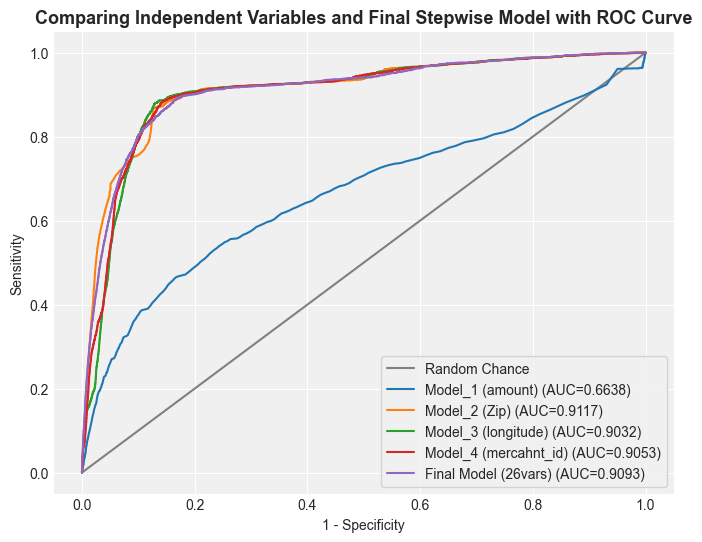

AUC values:
Model_1 (amount): 0.6638
Model_2 (Zip): 0.9117
Model_3 (longitude): 0.9032
Model_4 (mercahnt_id): 0.9053
Final Model (26vars): 0.9093


In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_multiple_roc(models, model_names, test_df, target_col="is_fraud"):
    """
    models: list of fitted statsmodels.Logit models
    model_names: list of strings
    test_df: test dataframe
    """
    plt.figure(figsize=(8, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['axes.facecolor'] = '#f0f0f0'

    # 隨機機率線
    plt.plot([0, 1], [0, 1], color='gray', linestyle='-', label='Random Chance')

    auc_values = {}

    for model, name in zip(models, model_names):
        # 取出模型變數
        vars_used = model.params.index.drop("const")
        X_test = sm.add_constant(test_df[vars_used])

        # 計算預測機率
        y_true = test_df[target_col]
        y_score = model.predict(X_test)

        # ROC 曲線
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        auc_values[name] = auc_val

        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.4f})")

    plt.title("Comparing Independent Variables and Final Stepwise Model with ROC Curve", fontsize=13, fontweight='bold')
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.legend(loc="lower right", frameon=True)
    plt.show()

    # 印出 AUC summary
    print("AUC values:")
    for name, val in auc_values.items():
        print(f"{name}: {val:.4f}")

# 假設你已經有以下模型：
# model_1 = sm.Logit(y_train, sm.add_constant(X_train[["X13"]])).fit(disp=False)
# model_2 = sm.Logit(y_train, sm.add_constant(X_train[["X17"]])).fit(disp=False)
# final_model = ...

# 範例呼叫
plot_multiple_roc(
    models=[model_0, model_2, model_3,model_4, final_model],
    model_names=["Model_1 (amount)", "Model_2 (Zip)", "Model_3 (longitude)","Model_4 (mercahnt_id)", "Final Model (26vars)"],
    test_df=test_df,
    target_col="is_fraud"
)


In [ ]:
cutoff_table_zoom.to_csv("cutoff_table_zoom(test).csv", index=False)

overall_fit, coef_df, not_in_eq_df, final_model

In [52]:
dfs = [overall_fit, coef_df, not_in_eq_df, final_model]
names = ["overall_fit", "coef_df", "not_in_eq_df"]

for df, name in zip(dfs, names):
    df.to_csv(f"{name}.csv", index=False)